<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/export_pills.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-wherediddavidgo')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [ ]:
vector_centerlines = ee.FeatureCollection('projects/ee-wherediddavidgo/assets/s2_platte_centerlines')
spaced_pts = ee.FeatureCollection('projects/ee-wherediddavidgo/assets/platte_pts_10000m')
all_pts = ee.FeatureCollection('projects/ee-wherediddavidgo/assets/platte_points')

## Functions

In [80]:
def buffer_point_width(points, width_multiplier, square=False):
  def create_buffer(point):
    width = ee.Number(point.get('MLength')).divide(3)
    radius = width.multiply(width_multiplier)
    new_buff = point.geometry().buffer(radius)
    if square:
        return(ee.Feature(point.set({'radius': radius, 'width_m': width})).setGeometry(new_buff.bounds()))
    else:
        return(ee.Feature(point.set({'radius': radius, 'width_m': width})).setGeometry(new_buff))
  return(points.map(create_buffer))



def convert_to_pill(segments, width_multiplier):
  def buffer(segment):
    width = ee.Number(segment.get('width_m'))
    pill = segment.geometry().buffer(width.multiply(width_multiplier))
    return(segment.setGeometry(pill))
  return segments.map(buffer)


def filter_dissolve_pills(bboxes, vlines):

  def filter_pills_within_bounds(bbox):

    filtered_lines = vlines.filterBounds(bbox.geometry())
    pills = convert_to_pill(filtered_lines, 3)
    connected_pill = pills.geometry().dissolve()
    return(bbox.setGeometry(connected_pill))

  return(bboxes.map(filter_pills_within_bounds))

def add_rivlength(f):
  selected_lines = vector_centerlines.filterBounds(f.geometry())
  length = ee.Number(selected_lines.geometry().length())
  return f.set({'riv_length': length})

def add_iindex_property(img):
  return(img.set({'iindex': iindex}))


def split_multipolygon(mpf):
    def get_by_index(index):
        pcoords = mpg.coordinates().get(index)
        polygon = ee.Geometry.Polygon(pcoords)
        return ee.Feature(polygon, mpf.toDictionary())


    mpg = mpf.geometry()
    nps = mpg.coordinates().size()
    plist = ee.List.sequence(0, nps.subtract(1))

    pfeats = plist.map(get_by_index)
    return(ee.FeatureCollection(pfeats))


def get_nonoverlap(union_feature):
    union_geom = union_feature.geometry()
    intersecting = circles_3x.filterBounds(union_geom)
#   // var list = intersecting.toList(intersecting.size());
#   // var randIndex = ee.Number.random().multiply(list.size()).floor();
    random_feature = ee.Feature(intersecting.sort('random_index').first())

    return random_feature

## Main

In [ ]:
filtered_pts = spaced_pts.filter(ee.Filter.neq('iindex', 186160))

In [ ]:
# ashland = 201625 # 06801000
# ashland_u = 153085
# ashland_d = 201888
# waterloo = 246043 # 06800500
# waterloo_u = 246016
# waterloo_d = 246048
# louisville = 202726 # 06805500
# louisville_u = 203066
# louisville_d = 202446
# nickerson = 120725 # 06800000
# nickerson_u = 120445
# nickerson_d = 120748
# thedford = 94011 # 06775900
# thedford_u = 93932
# thedford_d = 94005
# northgate = 41913 # 06620000
# northgate_d = 41900
# northgate_u = 41930
# gage_pts = all_pts.filter(ee.Filter.inList('iindex', [ashland, ashland_u, ashland_d, waterloo, waterloo_u, waterloo_d, louisville, louisville_u, louisville_d, nickerson, nickerson_u, nickerson_d, thedford, thedford_u, thedford_d, northgate, northgate_u, northgate_d]))



pts = pd.read_csv('/content/drive/MyDrive/effwidth_results/gage_sites/val_gages_2.csv')
gage_pts = all_pts.filter(ee.Filter.inList('iindex', pts.iindex.tolist()))
# gage_pts

In [83]:
def flag_bad(point):
    kval = ee.Algorithms.If(
        ee.Number(point.get('iindex')).eq(68202)\
        .And(ee.Number(point.geometry().coordinates().get(0)).add(99).abs().gt(1)),
        0, 1)
    return point.set('keep', kval)

gage_pts = gage_pts.map(flag_bad).filter(ee.Filter.eq('keep', 1))

In [84]:
gage_bboxes_15x = buffer_point_width(gage_pts, 15, True)
gage_circles_3x = buffer_point_width(gage_pts, 3, False)
gage_small_pills = filter_dissolve_pills(gage_circles_3x, vector_centerlines)

In [ ]:
bboxes_15x = buffer_point_width(filtered_pts, 15, True)
pills = (filter_dissolve_pills(bboxes_15x, vector_centerlines))
circles_3x = buffer_point_width(filtered_pts, 3, False)

NameError: name 'filtered_pts' is not defined

In [ ]:
circles_3x = circles_3x.randomColumn('random_index', seed=10)

union = circles_3x.union()


distinct = split_multipolygon(union).map(get_nonoverlap)

distinct = distinct.map(add_rivlength)



NameError: name 'circles_3x' is not defined

In [ ]:
gage_circles_3x = gage_circles_3x.map(add_rivlength)

In [ ]:
valid_iidxs = ee.List(distinct.reduceColumns(reducer=ee.Reducer.toList(), selectors=['iindex']).get('list'))


NameError: name 'distinct' is not defined

In [ ]:
points_no_overlap = filtered_pts.filter(ee.Filter.inList('iindex', valid_iidxs))
squares_15x = buffer_point_width(points_no_overlap, 15, True)
circles_15x = buffer_point_width(points_no_overlap, 15, False)

In [ ]:
pills = filter_dissolve_pills(circles_15x, vector_centerlines)
smallpills = filter_dissolve_pills(distinct, vector_centerlines)

In [85]:
# task = ee.batch.Export.table.toDrive(collection=gage_small_pills, description='gage_pills_3L_3W_20250918', fileFormat='SHP', fileNamePrefix='gage_pills_3L_3W_20250918', selectors=['iindex', 'geometry'])
# task.start()

# task = ee.batch.Export.table.toDrive(collection=gage_bboxes_15x, description='gage_squares_15x_20250918', fileFormat='SHP', fileNamePrefix='gage_squares_15x_20250918', selectors=['iindex', 'geometry'])
# task.start()

# task = ee.batch.Export.table.toDrive(collection=gage_circles_3x, description='gage_circles_3x_20250918', fileFormat='SHP', fileNamePrefix='gage_circles_3x_20250918', selectors=['iindex', 'geometry', 'radius', 'riv_length'])
# task.start()

task = ee.batch.Export.table.toDrive(collection=gage_pts, description='gage_points_20250918', fileFormat='SHP', fileNamePrefix='gage_points_20250918', selectors=['iindex', 'geometry'])
task.start()

In [82]:
gage_pts.select('iindex', 'geometry')

In [ ]:
task = ee.batch.Export.table.toDrive(collection=all_pts, description='all_pts', fileFormat='SHP', fileNamePrefix='platte_points', selectors=['iindex', 'geometry'])
task.start()

In [ ]:
Map = geemap.Map()
Map.addLayer(gage_pts.geometry(), {'color': 'blue'})
Map.addLayer(gage_circles_3x.geometry(), {'color': 'green'})
Map.addLayer(gage_bboxes_15x.geometry(), {'color': 'orange'})
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
import geopandas as gpd
from google.colab import drive
from matplotlib import pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pills = gpd.read_file('/content/drive/MyDrive/pills_3x_width_20250903.shp')
pills


,MLength,iindex,riv_length,radius,width_m,geometry
0,150.0,91451,351.808250,150.0,50.0,"POLYGON ((-107.06791 41.88329, -107.0679 41.88..."
1,108.0,103854,244.937503,108.0,36.0,"POLYGON ((-106.95619 41.60135, -106.95618 41.6..."
2,93.0,94634,243.165078,93.0,31.0,"POLYGON ((-106.95125 41.62302, -106.95124 41.6..."
3,84.0,78721,205.946738,84.0,28.0,"POLYGON ((-106.98833 41.80188, -106.98833 41.8..."
4,159.0,105269,388.114298,159.0,53.0,"POLYGON ((-106.91556 41.55521, -106.91556 41.5..."
...,...,...,...,...,...,...
440,1758.0,204343,3731.620703,1758.0,586.0,"POLYGON ((-96.30632 41.0204, -96.30624 41.0248..."
441,1590.0,82271,3761.556752,1590.0,530.0,"POLYGON ((-96.75696 41.85783, -96.75689 41.861..."
442,342.0,44897,748.492381,342.0,114.0,"POLYGON ((-96.9348 41.98843, -96.93478 41.9893..."
443,1449.0,130813,3089.601833,1449.0,483.0,"POLYGON ((-97.07999 41.40982, -97.07992 41.413..."


<Axes: >

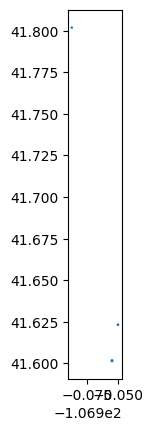

In [ ]:
pills.loc[1:3].plot()